In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
from matplotlib import collections as mc
from matplotlib import cm
import pandas as pd
import numpy as np
import copy
%aimport BEP_PM

In [2]:
# log = importer.apply('C:/Users/20173939/Documents/Study/BEP/Road_Traffic_Fine_Management_Process.xes')
# rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', log)
# rf.clean_timezone()
# rf.save()

In [185]:
# Reloading an already saved log named 'roadfines':
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', resource_id='org:resource')

In [186]:
rf.event_count

{('Create Fine', 'Send Fine'): 20755,
 ('Create Fine', 'Send for Credit Collection'): 58997,
 ('Create Fine', 'Payment'): 67201,
 ('Create Fine', 'Send Appeal to Prefecture'): 3144,
 ('Create Fine', 'Appeal to Judge'): 134,
 ('Create Fine', 'Notify Result Appeal to Offender'): 86,
 ('Create Fine', 'Receive Result Appeal from Prefecture'): 53}

In [187]:
# Manual reordering to match paper's segment order:
segments = rf.filter_segments()
segments[-1], segments[-2] = segments[-2], segments[-1] 
segments.insert(0, segments.pop(-1))
segments[-1], segments[-2] = segments[-2], segments[-1] 

In [188]:
height = 40
rf.performance_spectrum(segments, x_max=int(1500), segment_height=height)
rf.classify(rf.pf, metric=['start_time', 'end_time'], classifier=rf.batch_classifier, args=[10,0,1], inplace=True)

In [189]:
rf.pf['segment_index'] = (rf.pf['segment_index']) * 2

In [190]:
cols = list(rf.pf.columns)
cols.remove('segment_index')

In [206]:
# Using batch classifier to indicate if corrected trace was in a batch.
# This is because it is hard to see which traces where batched once the times have been adjusted.

# Sort per resource.
df = rf.pf.sort_values(['resource','start_time', 'end_time'])
current = None
last_end = None
prev = None
corrected = {}
causes = {}
busy = {}
for ind, row in df.iterrows():
    if row['resource'] != current: # Switching to new resource. 
        current = row['resource']
        last_end = None
    if last_end is not None and last_end['end_time'] > row['start_time']:
        # The worker was busy during the start of this event, correcting.
        if ind not in busy:
            busy[ind] = [ind]
        else:
            busy[ind].append(ind)
        corrected[prev] = row['start_time']
        if last_end['class'] == 1:
            causes[prev] = 1  # Batch is cause.
        else:
            causes[prev] = 0  # No batch, but still a cause. 
    last_end = row
    prev = ind
    
df['busy'] = df.index.map(busy)
df['waiting_time'] = df['end_time']- df.index.map(corrected)
df['end_time'] = df.index.map(corrected)
df['cause'] = df.index.map(causes)
df['batch'] = df['class']
df = df.sort_index()

In [193]:
for i in range(len(segments)):
    new_rows = df[df['segment_index'] == i*2][cols].copy()
    new_rows['segment_index'] = i*2+1
    rf.pf = rf.pf.append(new_rows, sort=True)

In [194]:
y_s = []
max_y = rf.pf['start_y'].max()
for segment in range(0, len(segments)*2):
    start =  (max_y*2) - (segment*height)
    end = (max_y*2) - (segment*height) - height
    rf.pf.loc[rf.pf['segment_index'] == segment, 'start_y'] = start
    rf.pf.loc[rf.pf['segment_index'] == segment, 'end_y'] = end
    y_s.append([start,end])
rf.y_s = y_s

In [195]:
new_segments = []
for segment in rf.segments:
    new_segments.append(segment)
    new_segments.append((segment[0], segment[1]+'1'))

In [196]:
rf.segments = new_segments

In [197]:
rf.pf

,case_id,class,duration,end_time,end_y,resource,segment_index,segment_name,start_time,start_y
0,23766,0.0,10,500.0,440,9,0,"(Create Fine, Payment)",490,480
1,23767,2.0,90,238.0,360,27,2,"(Create Fine, Send Fine)",148,400
2,23767,1.0,19,257.0,280,27,4,"(Send Fine, Insert Fine Notification)",238,320
3,23767,1.0,60,317.0,200,27,6,"(Insert Fine Notification, Add penalty)",257,240
4,23767,2.0,23,340.0,120,27,8,"(Add penalty, Payment)",317,160
...,...,...,...,...,...,...,...,...,...,...
128762,150364,1.0,376,1094.0,0,25,11,"(Add penalty, Send for Credit Collection)",1094,40
128766,150365,1.0,371,1100.0,0,25,11,"(Add penalty, Send for Credit Collection)",1099,40
128771,150367,1.0,372,1098.0,0,25,11,"(Add penalty, Send for Credit Collection)",1098,40
128775,150368,1.0,376,1096.0,0,25,11,"(Add penalty, Send for Credit Collection)",1094,40


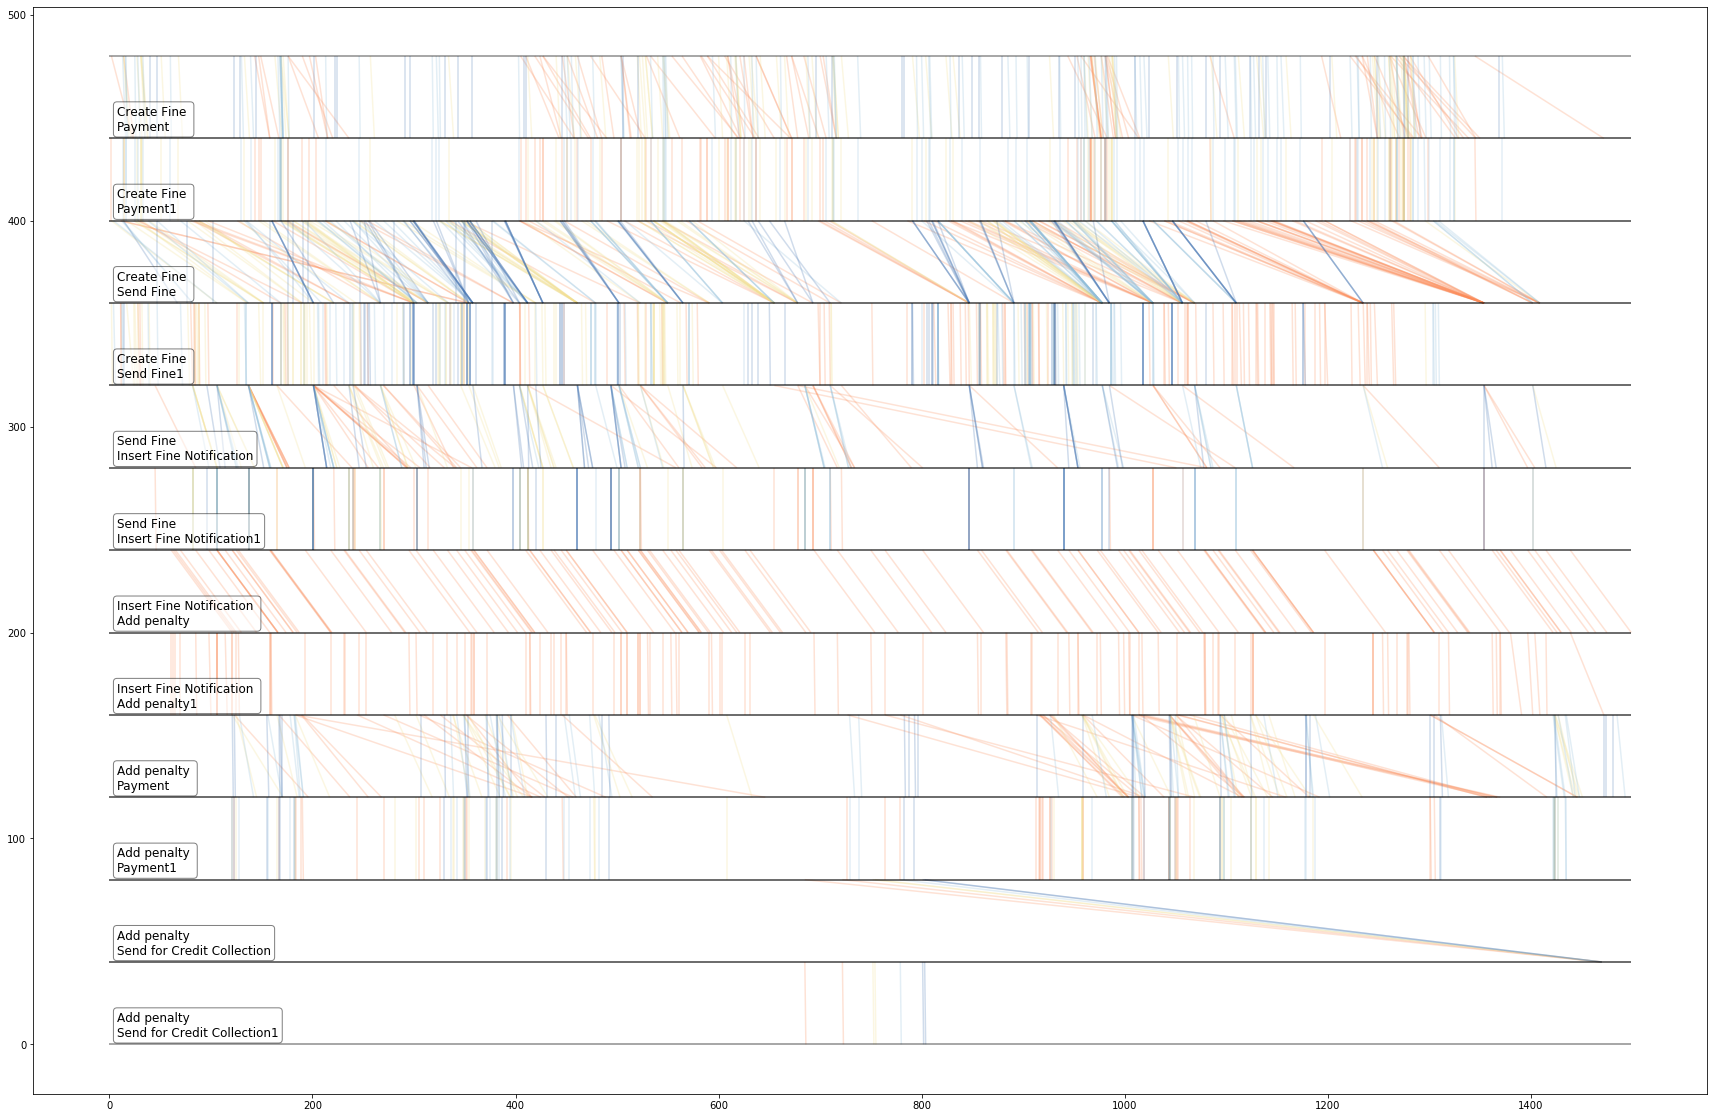

In [209]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
outlier_workers = list(dict(df.groupby('resource')['waiting_time'].sum().sort_values(ascending=False)).keys())[:1]
mask = (rf.pf['resource'].isin(outlier_workers))  & (rf.pf['class'] == 0) #& outliers
fig, ax = plt.subplots(figsize=[30,20])
rf.plot_performance_spectrum(class_colors, ax, mask=mask, compare='local', classifier=rf.classify_duration_hist, args=[4], metric='duration')

In [8]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.pf['waiting_time'] = rf.pf['waiting_time'].fillna(0)
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=rf.pf['class']==0, metric='waiting_time', classifier=rf.classify_duration_hist, args=[4])

KeyError: 'waiting_time'

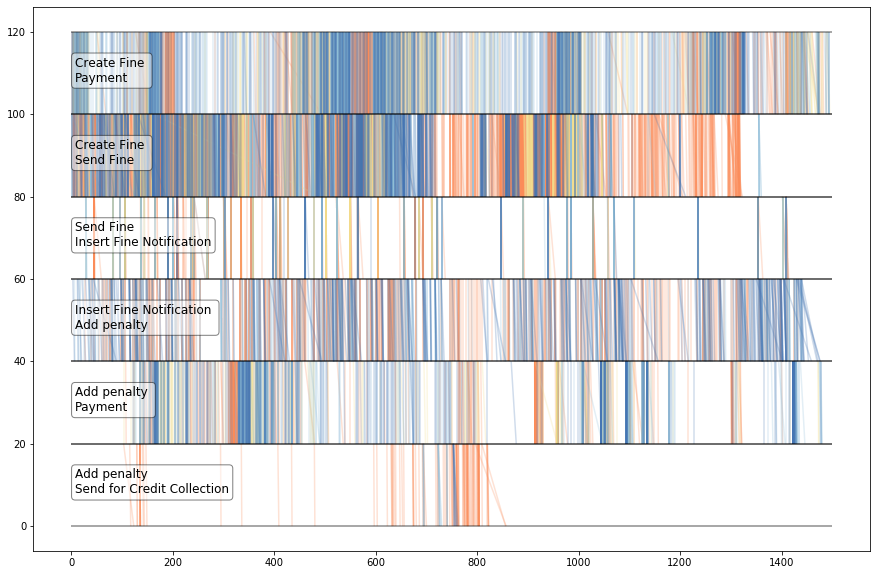

In [171]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=rf.pf['class']==0, end='correct_end', metric='waiting_time', classifier=rf.classify_duration_hist, args=[4])

In [166]:
# Using batch classifier to indicate if corrected trace was in a batch.
# This is because it is hard to see which traces where batched once the times have been adjusted.

# Sort per resource.
df = rf.classify(rf.pf, metric=['start_time', 'end_time'], classifier=rf.batch_classifier, args=[10,0,1])
df = rf.pf.sort_values(['resource','start_time', 'end_time'])
current = None
last_end = None
prev = None
corrected = {}
causes = {}
busy = {}
for ind, row in df.iterrows():
    if row['resource'] != current: # Switching to new resource. 
        current = row['resource']
        last_end = None
    if last_end is not None and last_end['end_time'] > row['start_time']:
        # The worker was busy during the start of this event, correcting.
        if ind not in busy:
            busy[ind] = [ind]
        else:
            busy[ind].append(ind)
        corrected[prev] = row['start_time']
        if last_end['class'] == 1:
            causes[prev] = 1  # Batch is cause.
        else:
            causes[prev] = 0  # No batch, but still a cause. 
    last_end = row
    prev = ind
    
df['busy'] = df.index.map(busy)
df['correct_end'] = df.index.map(corrected)
df['cause'] = df.index.map(causes)
df['batch'] = df['class']
rf.pf = df.sort_index()
rf.pf['waiting_time'] = rf.pf['end_time']-rf.pf['correct_end']
rf.pf['correct_duration'] = rf.pf['correct_end']-rf.pf['start_time']

In [68]:
# Outliers in waiting time (time on shelf) that where not in an end-batch.
outliers = ((rf.pf['waiting_time'] - rf.pf['waiting_time'].mean())/rf.pf['waiting_time'].std() > 1) 
outlier_workers = list(dict(rf.pf.groupby('resource')['waiting_time'].sum().sort_values(ascending=False)).keys())[:1]
mask = (rf.pf['resource'].isin(outlier_workers))  & (rf.pf['cause'] == 0) #& outliers

mask_busy = (~rf.pf['busy'].isna())&(rf.pf['resource'].isin(outlier_workers))
delayed = list(rf.pf[mask].index)
toplot = []
for ind, row in rf.pf[mask_busy].iterrows():
    for cause in row['busy']:
        if cause in delayed:
            if row['start_time'] != int(row['correct_end']):
                toplot.append([i for i in range(row['start_time'], int(row['correct_end'])+1)])
            else:
                toplot.append([row['start_time'], row['start_time']])
lines = [[(i[0],120), (i[1], 0)] for i in toplot]

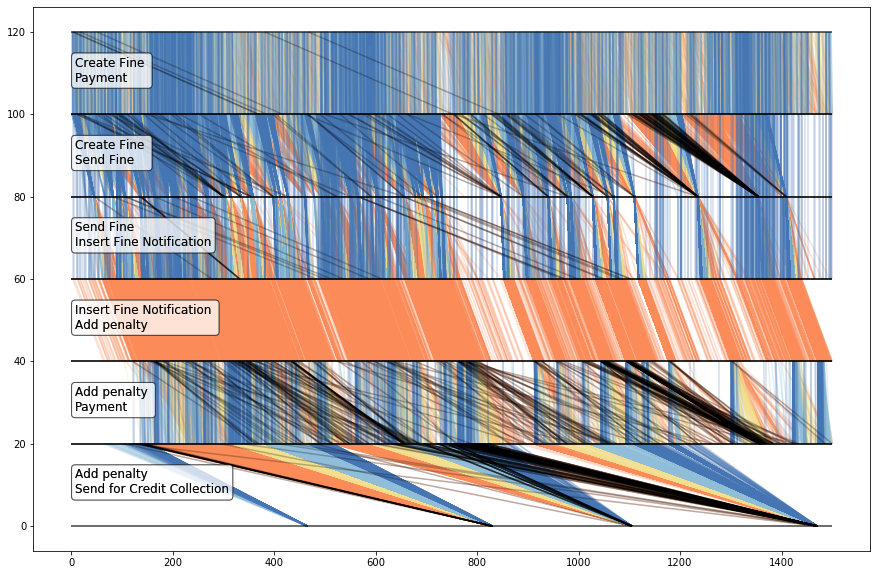

In [87]:
fig, ax = plt.subplots(figsize=[15,10])
# ax.add_collection(mc.LineCollection(lines, alpha=0.1))
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.plot_performance_spectrum(class_colors, ax, metric='duration', classifier=rf.classify_duration_hist, args=[4])
class_colors = [(0.5,0.5,0.5), (0,0,0)]
rf.plot_performance_spectrum(class_colors, ax, mask=mask, vis_mask=True, show_classes=[1])

(array([   0,   28,   56,   84,  112,  140,  168,  196,  224,  252,  280,
         308,  336,  364,  392,  420,  448,  476,  504,  532,  560,  588,
         616,  644,  672,  700,  728,  756,  784,  812,  840,  868,  896,
         924,  952,  980, 1008, 1036, 1064, 1092, 1120, 1148, 1176, 1204,
        1232, 1260, 1288, 1316, 1344, 1372, 1400, 1428, 1456, 1484]),
 <a list of 54 Text xticklabel objects>)

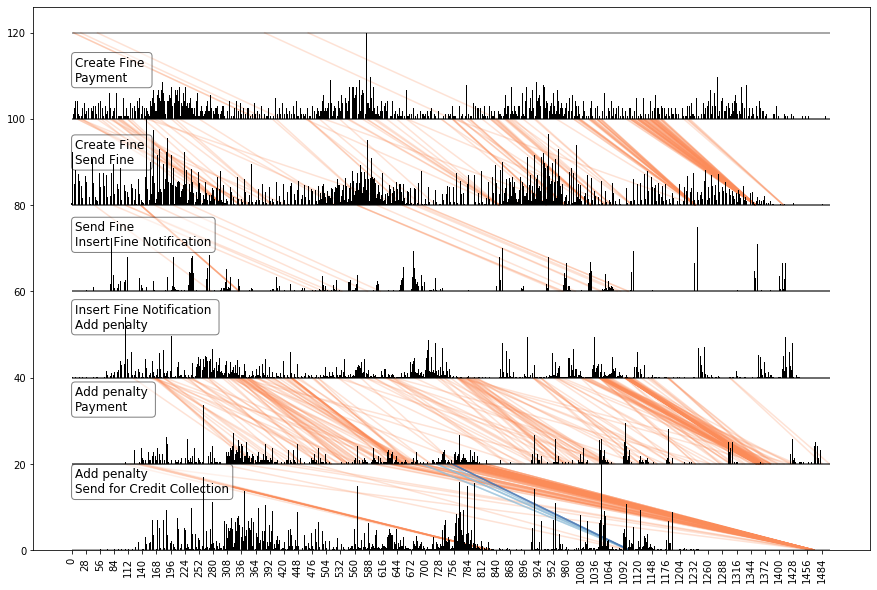

In [71]:
rf.pf['waiting_time'] = rf.pf['waiting_time'].fillna(0)
mask = (rf.pf['cause'] == 0) & ((rf.pf['waiting_time'] - rf.pf['waiting_time'].mean())/rf.pf['waiting_time'].std() > 0.5) 
resources = list(rf.pf[mask]['resource'].unique())
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=mask, metric='waiting_time', classifier=rf.classify_duration_hist, args=[4])
window=7
for s in range(len(segments)):
    df = rf.pf[(rf.pf['segment_index'] == s) & (rf.pf['resource'].isin(resources))]
    load_in_window = {i:[] for i in df['resource'].unique()}
    for i in range(0, max(df['end_time']), window):
        workload = dict(df[(df['start_time'] >= i) & (df['start_time'] <= i+window)].groupby('resource').count()['start_time'])
        for resource in df['resource'].unique():
            if resource in workload.keys():
                load_in_window[resource].append(workload[resource])
            else:
                load_in_window[resource].append(0)
    x, height = [],[]
    for k in range(len(load_in_window[list(load_in_window.keys())[0]])):
        load_per_time = list(pd.DataFrame(load_in_window).transpose()[k])
        x.extend([(k*7)+(window/len(load_per_time))*i for i in range(len(load_per_time))])
        height.extend([load for load in load_per_time])
    height = np.array(height)
    height = ((height-height.min()) / (height.max()-height.min())) * 20
    ax.bar(x,height, bottom=rf.y_s[s][1], color=(0,0,0),  zorder=10)
ax.set_xticks([i for i in range(0, rf.x_max, 28)])
plt.xticks(rotation=90)

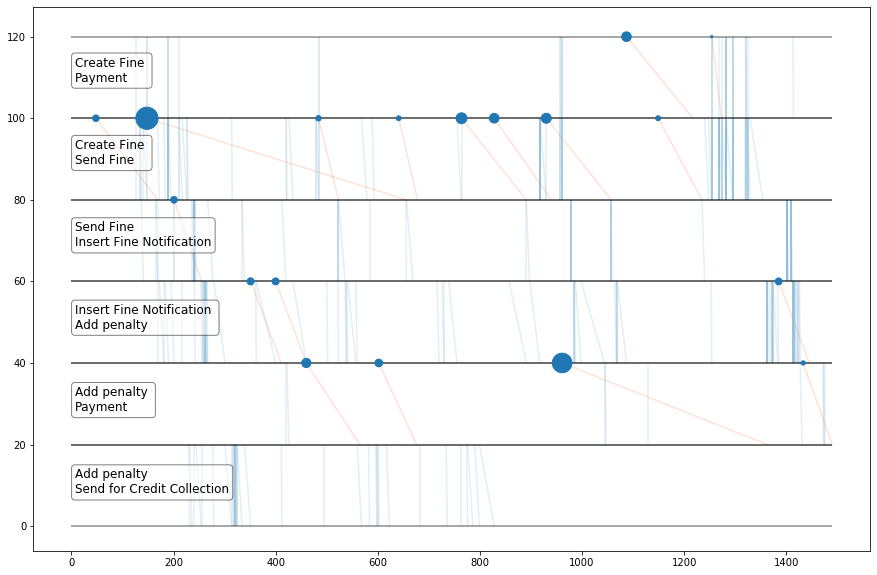

In [67]:
# Rebuilding the Performance Spectrum using corrected end time and corrected duration:
temp = copy.deepcopy(rf)
temp.build_coordinates(temp.pf['start_time'], temp.pf['correct_end'])
# rf.classify(metric='correct_duration', classifier=rf.classify_duration_hist, args=[4])
# mask = rf.pf['waiting_time'] > np.array(rf.pf.groupby('segment_index')['waiting_time'].mean()[rf.pf['segment_index']])
mask = ((rf.pf['correct_duration'] - rf.pf['correct_duration'].mean())/rf.pf['correct_duration'].std() > 3) & (rf.pf['batch'] == 0)
#mask = (rf.pf['class'] == 3) &   (rf.pf['batch'] == 0)
# rf.pf['class'] = 0
# for ind, row in rf.pf[mask].sort_values('waiting_time', ascending=False).head().iterrows():
#     # The lines that caused delay:
#     rf.pf.loc[mask & (rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource']), 'class'] = 1
#     if sum(mask & (rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource'])) != 0:
#         # The delayed segment:
#         rf.pf.loc[rf.pf.index == ind, 'class'] = 2


rf.pf.loc[mask&rf.pf['resource'].isin(most_delayed_resources), 'class'] = 3
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'class'] = 1
rf.build_coordinates(rf.pf['start_time'], rf.pf['end_time'])
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'start'] = temp.pf[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask)]['start']
rf.pf.loc[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask), 'end'] = temp.pf[(rf.pf['resource'].isin(most_delayed_resources)) & (~mask)]['end']


most_delayed_resources = list(dict(rf.pf[~rf.pf['delayed'].isna()]['resource'].value_counts()[:1]).keys())
for ind, row in rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)].iterrows():
    # The lines that caused delay:
    rf.pf.loc[(rf.pf['start_time'] < row['end_time']) & (rf.pf['end_time'] > row['correct_end']) & (rf.pf['end_time'] < row['end_time']) & (row['resource'] == rf.pf['resource']), 'delayer'] = 1

        
fig, ax = plt.subplots(figsize=[15,10])
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]
rf.plot_performance_spectrum(class_colors, ax, mask=(mask&rf.pf['resource'].isin(most_delayed_resources))|((rf.pf['resource'].isin(most_delayed_resources)) & (~mask) & (rf.pf['delayer'] == 1)))


# Adding a scatter plot with the waiting time for traces.
ax.scatter(rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['start_time'], rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['start_y'], s=rf.pf[mask&rf.pf['resource'].isin(most_delayed_resources)]['waiting_time'], zorder=10)

(array([   0,   28,   56,   84,  112,  140,  168,  196,  224,  252,  280,
         308,  336,  364,  392,  420,  448,  476,  504,  532,  560,  588,
         616,  644,  672,  700,  728,  756,  784,  812,  840,  868,  896,
         924,  952,  980, 1008, 1036, 1064, 1092, 1120, 1148, 1176, 1204,
        1232, 1260, 1288, 1316, 1344, 1372, 1400, 1428, 1456, 1484]),
 <a list of 54 Text xticklabel objects>)

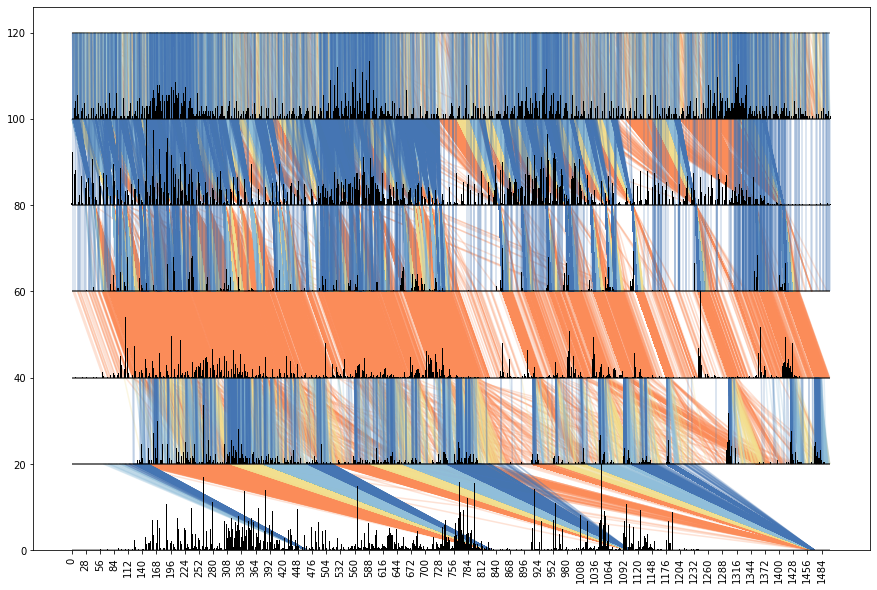

In [19]:
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax)
window=7
for s in range(len(segments)):
    df = rf.pf[rf.pf['segment_index'] == s]
    load_in_window = {i:[] for i in df['resource'].unique()}
    for i in range(0, max(df['end_time']), window):
        workload = dict(df[(df['start_time'] >= i) & (df['start_time'] <= i+window)].groupby('resource').count()['start_time'])
        for resource in df['resource'].unique():
            if resource in workload.keys():
                load_in_window[resource].append(workload[resource])
            else:
                load_in_window[resource].append(0)
    x, height = [],[]
    for k in range(len(load_in_window[list(load_in_window.keys())[0]])):
        load_per_time = list(pd.DataFrame(load_in_window).transpose()[k])
        x.extend([(k*7)+(window/len(load_per_time))*i for i in range(len(load_per_time))])
        height.extend([load for load in load_per_time])
    height = np.array(height)
    height = ((height-height.min()) / (height.max()-height.min())) * 20
    ax.bar(x,height, bottom=rf.y_s[s][1], color=(0,0,0),  zorder=10)
ax.set_xticks([i for i in range(0, rf.x_max, 28)])
plt.xticks(rotation=90)

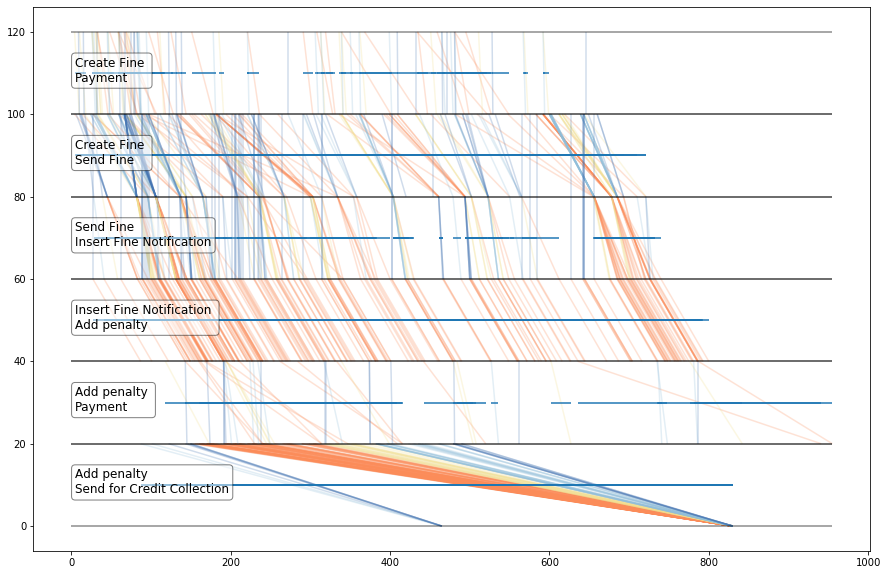

In [252]:
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['end_time'] <= 1000) & (rf.pf['resource'] == '27'))

y_s = [i for i in range(110, 0, -20)]
lines = []
for ind, data in rf.pf[rf.pf['resource'] == '27'].iterrows():
    if data['end_time'] <= 1000:
        line = [(data['start_time'], y_s[data['segment_index']]), (data['end_time'], y_s[data['segment_index']])]
        lines.append(line)
    
ax.add_collection(mc.LineCollection(lines))

In [11]:
workloads = []
for segment in range(len(segments)):
    mask = rf.pf['segment_index'] == segment

    working_times = {}
    for ind, data in rf.pf[mask].iterrows():
        if data['resource'] not in working_times:
            working_times[data['resource']] = [[data['start_time'], data['end_time']]]
        else:
            if data['start_time'] <= working_times[data['resource']][-1][-1]:
                # A resource was already working on something:
                if data['end_time'] > working_times[data['resource']][-1][-1]:
                    # Extending the known working time:
                    working_times[data['resource']][-1][-1] = data['end_time']
            else:
                working_times[data['resource']].append([data['start_time'], data['end_time']])

    workload = {}
    for resource in working_times:
        total = working_times[resource][-1][-1] - working_times[resource][0][0]
        if total == 0:
            workload[resource] = 0
        else:
            worked = sum((working_times[resource][i][1] - working_times[resource][i][0]) for i in range(len(working_times[resource])))
            workload[resource] = worked/total
    workloads.append(workload)

In [9]:
resources = rf.pf['resource'].unique()
load_df = pd.DataFrame(index=resources)
for workload,i in zip(workloads, range(len(segments))):
    for resource in resources:
        if resource not in workload.keys():
            workload[resource] = 0
    load_df['workload at ' + str(i)] = workload.values()

In [10]:
for i in range(len(segments)):
    load_df['mean duration at ' + str(i)] = rf.pf[rf.pf['segment_index'] == i].groupby('resource')['duration'].mean()

In [15]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPIC15_2.xes.xml')
rf = BEP_PM.EventLog('BPI15', 'concept:name', 'time:timestamp', log)
rf.clean_timezone()
rf.save()

In [16]:
rf = BEP_PM.EventLog('BPI15', 'concept:name', 'time:timestamp')
rf.count_trace_types()

{('01_HOOFD_010', '01_HOOFD_810'): 180,
 ('01_HOOFD_010', '01_HOOFD_820'): 196,
 ('01_HOOFD_010', '01_HOOFD_520'): 9,
 ('01_HOOFD_010', '01_HOOFD_530'): 15,
 ('01_HOOFD_010', '01_HOOFD_805'): 5,
 ('01_HOOFD_010', '01_HOOFD_195'): 2,
 ('01_HOOFD_030_2', '01_HOOFD_820'): 13,
 ('01_HOOFD_010', '01_HOOFD_101'): 4,
 ('01_HOOFD_010', '01_BB_770'): 94,
 ('01_HOOFD_010', '01_HOOFD_065_2'): 1,
 ('01_HOOFD_010', '01_BB_775'): 3,
 ('01_HOOFD_010', '01_HOOFD_516'): 3,
 ('01_HOOFD_010', '01_HOOFD_061'): 3,
 ('01_HOOFD_010', '08_AWB45_090_3'): 2,
 ('01_HOOFD_065_2', '01_HOOFD_516'): 1,
 ('01_HOOFD_010', '01_HOOFD_015'): 4,
 ('01_HOOFD_030_2', '01_HOOFD_195'): 1,
 ('01_HOOFD_010', '01_HOOFD_519'): 3,
 ('01_HOOFD_010', '14_VRIJ_060_3'): 1,
 ('01_HOOFD_010', '01_BB_705'): 1,
 ('01_HOOFD_010', '08_AWB45_025'): 5,
 ('01_HOOFD_010', '02_DRZ_010'): 1,
 ('01_HOOFD_010', '01_HOOFD_815'): 2,
 ('01_HOOFD_010', '01_HOOFD_101b'): 2,
 ('01_HOOFD_010', '16_LGSV_010'): 2,
 ('01_HOOFD_010', '01_HOOFD_250_2'): 1,
 ('

In [17]:
segments = rf.filter_segments(0.50, compare_to='first')

In [18]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]

rf.performance_spectrum(segments, x_max=int(5 * 365), metric='duration', classifier=rf.classify_duration_hist, args=[4])

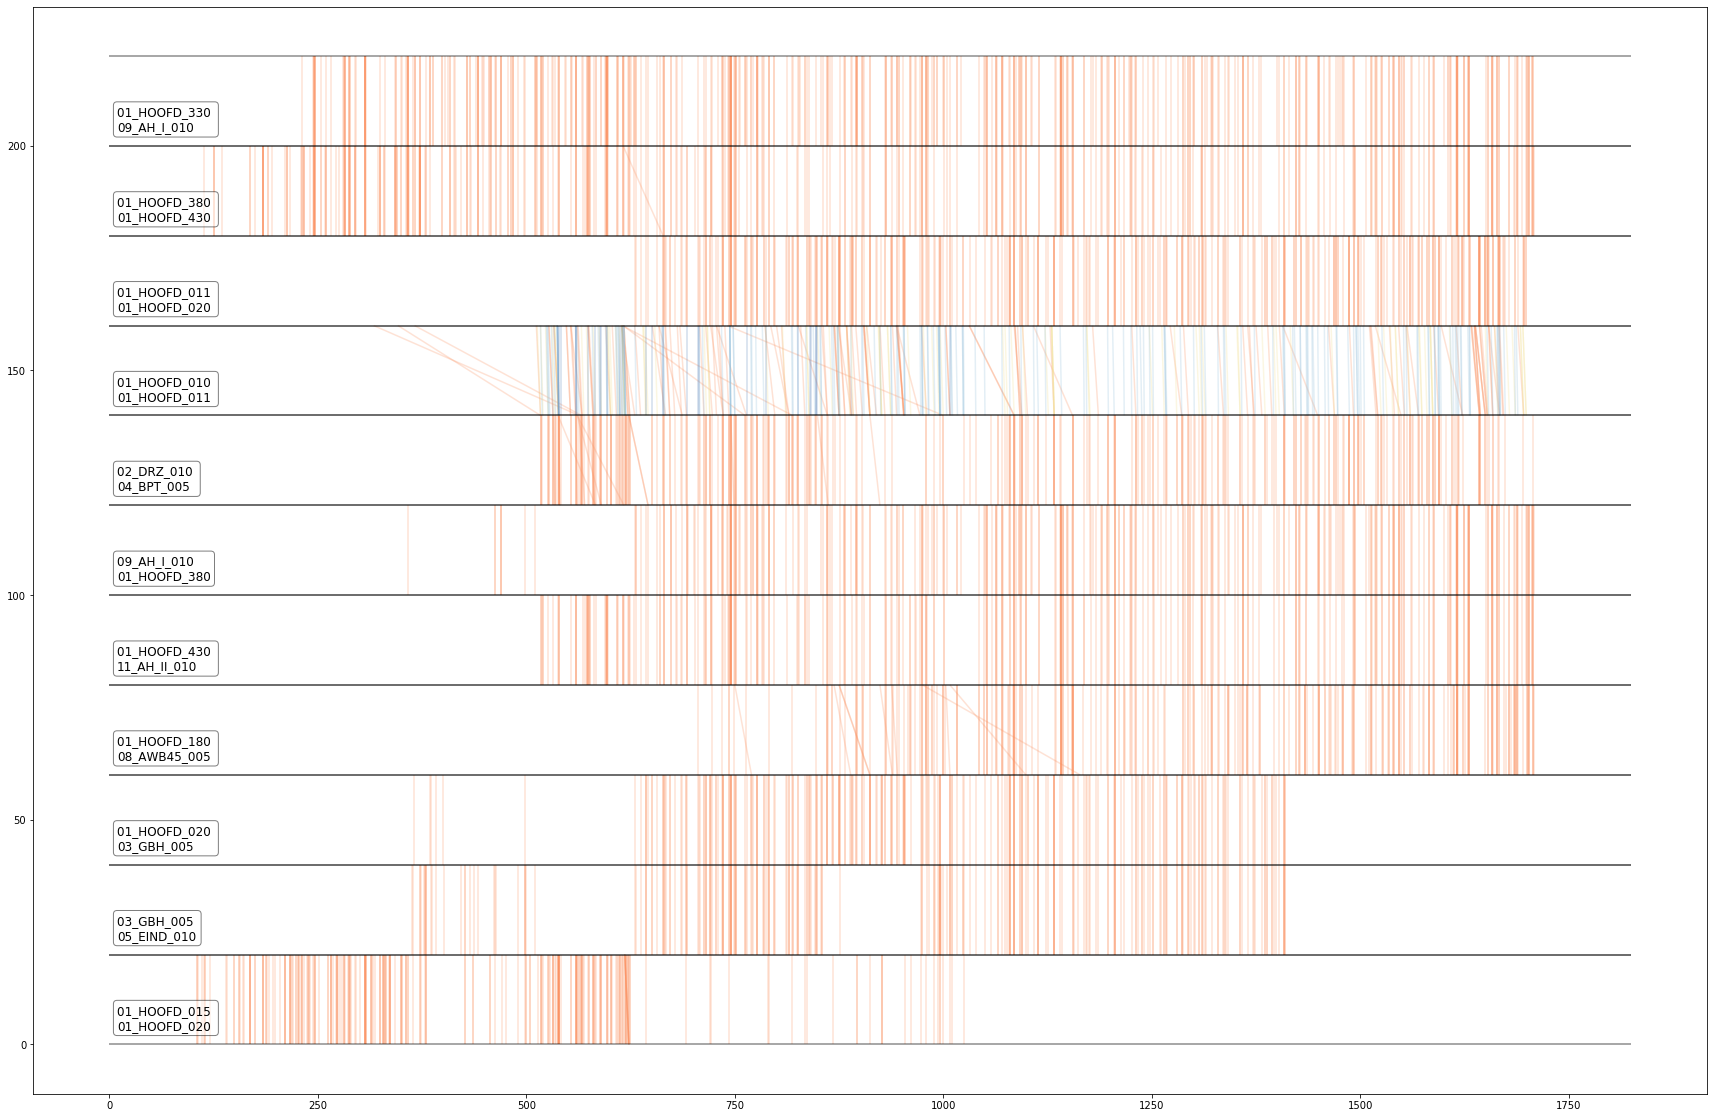

In [20]:
rf.plot_performance_spectrum(class_colors)

In [3]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPI Challenge 2017.xes')

In [5]:
log[0][0]

{'Action': 'Created', 'org:resource': 'User_1', 'concept:name': 'A_Create Application', 'EventOrigin': 'Application', 'EventID': 'Application_652823628', 'lifecycle:transition': 'complete'}

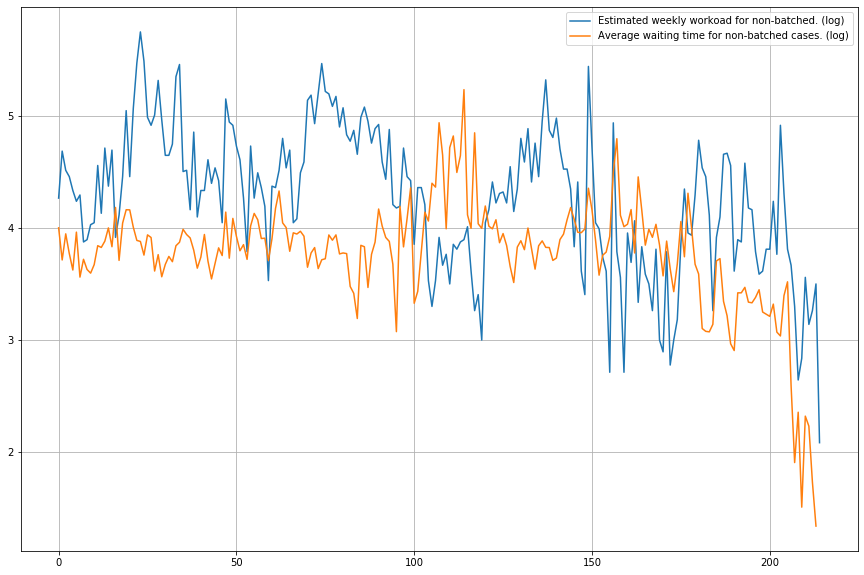

In [145]:
df = rf.pf.sort_values('start_time').copy()
x1 = np.array([list(df[(df['start_time'] >= i)&(df['start_time'] <= i+7) & (df['batch']==0)].count())[0] for i in range(0, df['start_time'].max(), 7)])
x2 = np.array([df[(df['start_time'] >= i)&(df['start_time'] <= i+7)&(df['cause'] == 0) ]['waiting_time'].mean() for i in range(0, df['start_time'].max(), 7)])
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(np.log(x1+1), label='Estimated weekly workoad for non-batched. (log)')
ax.plot(np.log(x2+1), label='Average waiting time for non-batched cases. (log)')
ax.legend()
ax.grid()

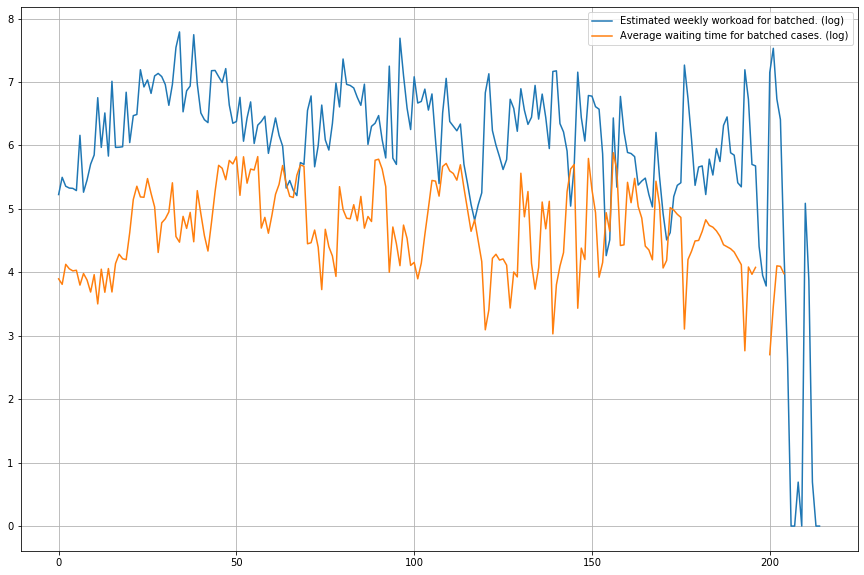

In [146]:
df = rf.pf.sort_values('start_time').copy()
x1 = np.array([list(df[(df['start_time'] >= i)&(df['start_time'] <= i+7) & (df['batch']>0)].count())[0] for i in range(0, df['start_time'].max(), 7)])
x2 = np.array([df[(df['start_time'] >= i)&(df['start_time'] <= i+7)&(df['cause'] == 1) ]['waiting_time'].mean() for i in range(0, df['start_time'].max(), 7)])
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(np.log(x1+1), label='Estimated weekly workoad for batched. (log)')
ax.plot(np.log(x2+1), label='Average waiting time for batched cases. (log)')
ax.legend()
ax.grid()

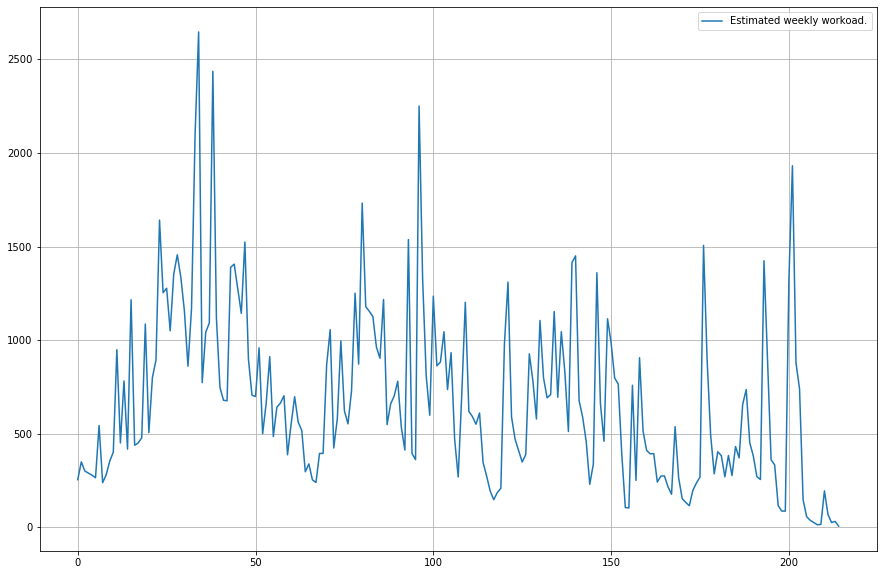

In [151]:
outlier = df['waiting_time'].mean()+df['waiting_time'].std()
df = rf.pf.sort_values('start_time').copy()
x1 = np.array([list(df[(df['start_time'] >= i)&(df['start_time'] <= i+7)].count())[0] for i in range(0, df['start_time'].max(), 7)])
fig, ax = plt.subplots(figsize=[15,10])
ax.plot(x1, label='Estimated weekly workoad.')
ax.legend()
ax.grid()